# This Jupyter Notebook is divided into the following sections:

### 1. Importing and exploring CSV data
### 2. Ingesting raw data into Postgres
### 3. Cleaning raw data 
### 4. Storing refined data into Postgres
### 5. Exploring data through visualizations

##### Please follow the sections below and read the comments in case you have any questions.

# 1. Importing and exploring CSV data

In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
from sqlalchemy import create_engine
import locale

In [2]:
# Set display options to show the full numbers
pd.set_option('display.float_format', '{:.0f}'.format)

# Set display option to allow displaying multiple rows
pd.set_option('display.max_rows', None)

In [3]:
# Define the file paths
raw_inbound = '../dataset/API_ST.INT.ARVL_DS2_en_csv_v2_1927083.csv'
raw_outbound = '../dataset/API_ST.INT.DPRT_DS2_en_csv_v2_1929304.csv'
raw_expenditure = '../dataset/API_ST.INT.XPND.CD_DS2_en_csv_v2_1929314.csv'

# Read CSV files and create dataframes
df_inbound = pd.read_csv(raw_inbound)
df_outbound = pd.read_csv(raw_outbound)
df_expenditure = pd.read_csv(raw_expenditure)

# Replace NaN values with null columns to enable Postgres ingestion
df_inbound = df_inbound.where(pd.notnull(df_inbound), None)
df_outbound = df_outbound.where(pd.notnull(df_outbound), None)
df_expenditure = df_expenditure.where(pd.notnull(df_expenditure), None)

In [4]:
# Printing DF stats
print(f" The shape of the First Data Frame is:   {df_inbound.shape} \n",
      f"The shape of the Second Data Frame is:  {df_outbound.shape}\n", 
      f"The shape of the Third Data Frame is:   {df_expenditure.shape} ")

 The shape of the First Data Frame is:   (264, 65) 
 The shape of the Second Data Frame is:  (264, 65)
 The shape of the Third Data Frame is:   (264, 65) 


In [5]:
## Taking a closer look into one of the DFs

df_expenditure.head(50)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,287000000,294000000,342000000,351000000,359000000,332000000,362000000,358000000,NaN,NaN
1,Afghanistan,AFG,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,255000000,110000000,138000000,140000000,151000000,89000000,130000000,226000000,NaN,NaN
2,Angola,AGO,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,323000000,288000000,316000000,505000000,389000000,823000000,1216000000,762000000,NaN,NaN
3,Albania,ALB,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1677000000,1374000000,1567000000,1689000000,1311000000,1338000000,1473000000,1750000000,NaN,NaN
4,Andorra,AND,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arab World,ARB,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,69398949596,76367594532,82441703811,92674938749,94058239130,91176828190,95771662433,95604213053,NaN,NaN
6,United Arab Emirates,ARE,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,13206000000,15072000000,16188000000,15848000000,16637000000,17127000000,17645000000,17999000000,NaN,NaN
7,Argentina,ARG,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,7602000000,8466000000,8421000000,7837000000,9348000000,12273000000,14175000000,13092000000,NaN,NaN
8,Armenia,ARM,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,756000000,874000000,1007000000,1101000000,1057000000,1119000000,1325000000,1458000000,NaN,NaN
9,American Samoa,ASM,"International tourism, expenditures (current US$)",ST.INT.XPND.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Ingesting raw data into Postgres

In [6]:
## Connecting to PostgresDB

conn = psycopg2.connect("host=127.0.0.1 port=7000 dbname=postgres user=postgres password=example")
cursor = conn.cursor()

In [7]:
## Creating engine that will be later on used to facilitate ingestion

# Assuming your connection details are the following:
host = '127.0.0.1'
port = '7000'
dbname = 'postgres'
user = 'postgres'
password = 'example'

# Construct the connection string
connection_string = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

# Create the engine
engine = create_engine(connection_string)

In [8]:
## Creating tables using the create_tables.sql script

# Read the SQL file
with open('create_tables.sql', 'r') as file:
    sql_queries = file.read()

# Remove whitespace and newlines
sql_queries = [query.strip() for query in sql_queries.split(';') if query.strip()]

# Rollback the current transaction
# conn.rollback()

# Close and reopen the cursor
# cursor.close()
# cursor = conn.cursor()

# Execute the queries
for query in sql_queries:
    cursor.execute(query)

# Commit the changes
conn.commit()

In [9]:
## Double checking if tables were created succesfully

# Execute a query to retrieve the list of tables
cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='public';")

# Fetch all the table names
table_names = cursor.fetchall()

# Print the table names
for table_name in table_names:
    print(table_name[0])

raw_inbound
raw_outbound
raw_expenditure
refined_inbound
refined_outbound
refined_expenditure


In [10]:
# Preparing dataframe data to be ingested into Postgres with SQL Alchemy
df_inbound.rename(columns={"Country Name": "country_name", "Country Code": "country_code", "Indicator Name": "indicator_name", "Indicator Code": "indicator_code"}, inplace=True)
df_outbound.rename(columns={"Country Name": "country_name", "Country Code": "country_code", "Indicator Name": "indicator_name", "Indicator Code": "indicator_code"}, inplace=True)
df_expenditure.rename(columns={"Country Name": "country_name", "Country Code": "country_code", "Indicator Name": "indicator_name", "Indicator Code": "indicator_code"}, inplace=True)

In [11]:
# Insert the DataFrame into the database table
df_inbound.to_sql('raw_inbound', con=engine, if_exists='append', index=False)

# Commit the transaction explicitly
conn = engine.connect()
transaction = conn.begin()
try:
    # Commit the transaction explicitly
    transaction.commit()
    print("Transaction committed successfully.")
except:
    # Rollback the transaction in case of an exception
    transaction.rollback()
    print("Transaction rolled back.")

Transaction committed successfully.


In [12]:
# Insert the DataFrame into the database table
df_outbound.to_sql('raw_outbound', con=engine, if_exists='append', index=False)

# Commit the transaction explicitly
transaction = conn.begin()
try:
    # Commit the transaction explicitly
    transaction.commit()
    print("Transaction committed successfully.")
except:
    # Rollback the transaction in case of an exception
    transaction.rollback()
    print("Transaction rolled back.")

Transaction committed successfully.


In [13]:
# Insert the DataFrame into the database table
df_expenditure.to_sql('raw_expenditure', con=engine, if_exists='append', index=False)

# Commit the transaction explicitly
conn = engine.connect()
transaction = conn.begin()
try:
    # Commit the transaction explicitly
    transaction.commit()
    print("Transaction committed successfully.")
except:
    # Rollback the transaction in case of an exception
    transaction.rollback()
    print("Transaction rolled back.")

Transaction committed successfully.


In [14]:
## Checking if data was inserted into the tables
table_names = ['raw_inbound', 'raw_outbound', 'raw_expenditure']

# Iterate over the table names
for table_name in table_names:
    # Execute the SELECT COUNT(*) query
    query = f"SELECT COUNT(*) FROM {table_name}"
    cursor.execute(query)

    # Fetch the result
    row_count = cursor.fetchone()[0]

    # Print the table name and row count
    print(f"{table_name}: {row_count} rows")

raw_inbound: 264 rows
raw_outbound: 264 rows
raw_expenditure: 264 rows


In [15]:
## Taking a closer look into one of the tables to explore the data

# Execute the SELECT query on the desired table
table_name = 'raw_inbound'
query = f"SELECT * FROM {table_name}"
cursor.execute(query)

# Fetch all rows from the cursor
rows = cursor.fetchall()

# Get the column names from the cursor description
column_names = [desc[0] for desc in cursor.description]

# Create a DataFrame from the fetched rows and column names
df = pd.DataFrame(rows, columns=column_names)

# Display the first 50 rows of the DataFrame
df.head(50)

,country_name,country_code,indicator_name,indicator_code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,869000,904000,979000,1072000,1225000,1102000,1070500,1082000,None,None
1,Afghanistan,AFG,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,Angola,AGO,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,481000,528000,650000,595000,592000,397000,261000,218000,None,None
3,Albania,ALB,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,2469000,3156000,2857000,3341000,3784000,4070000,4643000,5340000,None,None
4,Andorra,AND,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,2242000,2238000,2328000,2363000,2663000,2819000,3003000,3042000,None,None
5,Arab World,ARB,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,76660006,84844588,85114141,90876674,88169233,87721747,94181176,101463695,None,None
6,United Arab Emirates,ARE,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,NaN,NaN,NaN,16232000,17472000,18967000,20394000,21286000,None,None
7,Argentina,ARG,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,6703000,6497000,6510000,7165000,6816000,6668000,6711000,6942000,None,None
8,Armenia,ARM,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,758000,963000,1084000,1204000,1192000,1260000,1495000,1652000,None,None
9,American Samoa,ASM,"International tourism, number of arrivals",ST.INT.ARVL,None,None,None,None,None,None,...,22600,22600,20800,21600,20300,20100,20000,20200,None,None


# 3. Cleaning raw data

In [16]:
## Checking for NULL values (both NAN and NONE)

# List of dataframe names and corresponding dataframes
dataframes = [("df_inbound", df_inbound), ("df_outbound", df_outbound), ("df_expenditure", df_expenditure)]

def count_missing_values(df, name):
    missing_count = df.isnull().sum().sum()
    return missing_count

# Iterate over the dataframes list
for name, df in dataframes:
    missing_count = count_missing_values(df, name)
    print("Missing values in", name, "dataframe:", missing_count)

Missing values in df_inbound dataframe: 10555
Missing values in df_outbound dataframe: 13285
Missing values in df_expenditure dataframe: 10822


In [17]:
## Dropping all years before 2014

# Create a list of columns to keep
columns_to_keep = ['country_name', 'country_code', 'indicator_name', 'indicator_code', '2014', '2015', '2016', '2017', '2018']

# Select the desired columns in each dataframe
df_inbound = df_inbound[columns_to_keep]
df_outbound = df_outbound[columns_to_keep]
df_expenditure = df_expenditure[columns_to_keep]

In [18]:
## Dropping all columns where all the values are null

df_inbound.dropna(axis=1, how='all', inplace=True)
df_outbound.dropna(axis=1, how='all', inplace=True)
df_expenditure.dropna(axis=1, how='all', inplace=True)

C:\Users\marce\AppData\Local\Temp\ipykernel_5284\1499685057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inbound.dropna(axis=1, how='all', inplace=True)
C:\Users\marce\AppData\Local\Temp\ipykernel_5284\1499685057.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outbound.dropna(axis=1, how='all', inplace=True)
C:\Users\marce\AppData\Local\Temp\ipykernel_5284\1499685057.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [19]:
## Dropping all rows that don't have any yearly data

# List of columns to consider
columns_to_consider = ['country_name', 'country_code', 'indicator_name', 'indicator_code']

# Drop rows with all null values, except for the specified columns
df_inbound.dropna(subset=df_inbound.columns.difference(columns_to_consider), how='any', inplace=True)
df_outbound.dropna(subset=df_outbound.columns.difference(columns_to_consider), how='any', inplace=True)
df_expenditure.dropna(subset=df_expenditure.columns.difference(columns_to_consider), how='any', inplace=True)

C:\Users\marce\AppData\Local\Temp\ipykernel_5284\1749085583.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inbound.dropna(subset=df_inbound.columns.difference(columns_to_consider), how='any', inplace=True)
C:\Users\marce\AppData\Local\Temp\ipykernel_5284\1749085583.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outbound.dropna(subset=df_outbound.columns.difference(columns_to_consider), how='any', inplace=True)
C:\Users\marce\AppData\Local\Temp\ipykernel_5284\1749085583.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [20]:
## Repeating the operation above for checking for NULL values (both NAN and NONE)

# List of dataframe names and corresponding dataframes
dataframes = [("df_inbound", df_inbound), ("df_outbound", df_outbound), ("df_expenditure", df_expenditure)]

def count_missing_values(df, name):
    missing_count = df.isnull().sum().sum()
    return missing_count

# Iterate over the dataframes list
for name, df in dataframes:
    missing_count = count_missing_values(df, name)
    print("Missing values in", name, "dataframe:", missing_count)

Missing values in df_inbound dataframe: 0
Missing values in df_outbound dataframe: 0
Missing values in df_expenditure dataframe: 0


In [21]:
## Dropping useless columns

columns_to_drop = ['indicator_name', 'indicator_code']

df_inbound.drop(columns=columns_to_drop, inplace=True)
df_outbound.drop(columns=columns_to_drop, inplace=True)
df_expenditure.drop(columns=columns_to_drop, inplace=True)

In [22]:
## Exploring the dataframe to understand remaining values

# Sort the dataframe by descending order of column '2014'
df_outbound_sorted = df_outbound.sort_values(by='2014', ascending=False)

# Display the first 100 rows of the sorted dataframe
df_outbound_sorted.head(100)


,country_name,country_code,2014,2015,2016,2017,2018
257,World,WLD,1283554402,1336347111,1412965846,1504553383,1563555558
93,High income,HIC,670935986,701469335,742800519,784318352,814281150
196,Post-demographic dividend,PST,606784918,632956077,668714627,704095025,730981567
179,OECD members,OED,538581418,562799483,596453495,631416815,658490080
63,Europe & Central Asia,ECS,511096617,515940371,542882712,583015436,618355680
101,IDA & IBRD total,IBT,506303613,522601923,551072829,600065115,625518082
138,Low & middle income,LMY,467751030,482936181,509090957,551402287,574143267
154,Middle income,MIC,419254385,432921298,456239726,494146794,514531490
100,IBRD only,IBD,388521194,400963843,423266461,462033928,478800781
61,East Asia & Pacific,EAS,331757718,357381672,378524426,397445244,415030422


In [23]:
# Getting a list of country_codes in which 2014 values are higher than 126071343 (aggregated regions on the top of the list) to make filtering easier

# Filter the dataframe based on the condition and get the list of country codes
country_codes = df_outbound[df_outbound['2014'] > 126071343]['country_code'].tolist()

# Append additional country codes to the list that were manually spotted
additional_codes = ['LMC', 'NAC', 'LCN', 'TLA', 'LAC', 'CEB', 'TSA', 'MAC', 'ECA',
                    'HKG', 'MEA', 'ARB', 'SST', 'OSS', 'MNA', 'TMN', 'LDC', 'IDA', 'IDB', 'HPC', 'FCS', 'SAS', 'SSA', 'SSF', 'TSS']
country_codes += additional_codes

# Get the dictionary of all country codes and names from outbound
country_dict = df_outbound.set_index('country_code')['country_name'].to_dict()

# Iterate over rows in both df_inbound and df_expenditure
for (index_inbound, row_inbound), (index_expenditure, row_expenditure) in zip(df_inbound.iterrows(), df_expenditure.iterrows()):
    country_code_inbound = row_inbound['country_code']
    country_name_inbound = row_inbound['country_name']
    
    country_code_expenditure = row_expenditure['country_code']
    country_name_expenditure = row_expenditure['country_name']
    
    # Check if the country code from either dataframe is not already in the dictionary
    if country_code_inbound not in country_dict:
        # Add the missing entry to the dictionary from df_inbound
        country_dict[country_code_inbound] = country_name_inbound
    
    if country_code_expenditure not in country_dict:
        # Add the missing entry to the dictionary from df_expenditure
        country_dict[country_code_expenditure] = country_name_expenditure

    
# Print the country code and name for each country code in the country_codes list that we will exclude from the dataset
for code in country_codes:
        print(f"Country Code: {code}, Country Name: {country_dict[code]}")


Country Code: EAP, Country Name: East Asia & Pacific (excluding high income)
Country Code: EAR, Country Name: Early-demographic dividend
Country Code: EAS, Country Name: East Asia & Pacific
Country Code: ECS, Country Name: Europe & Central Asia
Country Code: EMU, Country Name: Euro area
Country Code: EUU, Country Name: European Union
Country Code: HIC, Country Name: High income
Country Code: IBD, Country Name: IBRD only
Country Code: IBT, Country Name: IDA & IBRD total
Country Code: LMY, Country Name: Low & middle income
Country Code: LTE, Country Name: Late-demographic dividend
Country Code: MIC, Country Name: Middle income
Country Code: OED, Country Name: OECD members
Country Code: PST, Country Name: Post-demographic dividend
Country Code: TEA, Country Name: East Asia & Pacific (IDA & IBRD countries)
Country Code: TEC, Country Name: Europe & Central Asia (IDA & IBRD countries)
Country Code: UMC, Country Name: Upper middle income
Country Code: WLD, Country Name: World
Country Code: LM

In [24]:
## Filtering aggregated regions from the dataframes

# Function to exclude country codes from a dataframe
def exclude_countries(df, country_codes):
    return df[~df['country_code'].isin(country_codes)].copy()

# Create a dictionary to map original dataframe names to their corresponding variables
dataframes = {
    'df_inbound': df_inbound,
    'df_outbound': df_outbound,
    'df_expenditure': df_expenditure
}

# Exclude country codes from each original dataframe and create new variables for the filtered dataframes
for df_name, df in dataframes.items():
    locals()[df_name + "_filtered"] = exclude_countries(df, country_codes)

# Print the filtered dataframes
for df_name, df_filtered in dataframes.items():
    print(f"{df_name}_filtered:")
    print(df_filtered.head())
    print()



df_inbound_filtered:
  country_name country_code     2014     2015     2016     2017      2018
0        Aruba          ABW  1072000  1225000  1102000  1070500   1082000
2       Angola          AGO   595000   592000   397000   261000    218000
3      Albania          ALB  3341000  3784000  4070000  4643000   5340000
4      Andorra          AND  2363000  2663000  2819000  3003000   3042000
5   Arab World          ARB 90876674 88169233 87721747 94181176 101463695

df_outbound_filtered:
   country_name country_code     2014     2015     2016     2017     2018
3       Albania          ALB  4146000  4504000  4852000  5186000  5415000
7     Argentina          ARG  6517000  7807000 10417000 12213000 11130000
8       Armenia          ARM  1198000  1187000  1263000  1482000  1623000
11    Australia          AUS  9480000  9810000 10390000 10932000 11403000
12      Austria          AUT 10994000 10628000 11534000 11491000 11883000

df_expenditure_filtered:
  country_name country_code        2014   

In [25]:
## Checking the dataframe again

# Sort the dataframe by descending order of column '2014'
df_inbound_sorted = df_inbound_filtered.sort_values(by='2018', ascending=False)

# Display the first 100 rows of the sorted dataframe
df_inbound_sorted.head(500)  

,country_name,country_code,2014,2015,2016,2017,2018
75,France,FRA,83701000,84452000,82682000,86758000,89322000
68,Spain,ESP,64939000,68175000,75315000,81869000,82773000
249,United States,USA,75379350,77773520,76407480,77186740,79745920
38,China,CHN,55622000,56886000,59270000,60740000,62900000
114,Italy,ITA,48576000,50732000,52372000,58253000,61567200
242,Turkey,TUR,39811000,39478000,30289000,37601000,45768000
152,Mexico,MEX,29346000,32093000,35079000,39291000,41313000
53,Germany,DEU,32999000,34970000,35555000,37452000,38881000
231,Thailand,THA,24810000,29923000,32530000,35592000,38178000
79,United Kingdom,GBR,32613000,34436000,35814000,37651000,36316000


# 4. Storing refined data into Postgres

In [26]:
# Insert the DataFrame into the database table
df_outbound_filtered.to_sql('refined_outbound', con=engine, if_exists='append', index=False)

# Commit the transaction explicitly
conn = engine.connect()
transaction = conn.begin()
try:
    # Commit the transaction explicitly
    transaction.commit()
    print("Transaction committed successfully.")
except:
    # Rollback the transaction in case of an exception
    transaction.rollback()
    print("Transaction rolled back.")


Transaction committed successfully.


In [27]:
# Insert the DataFrame into the database table
df_inbound_filtered.to_sql('refined_inbound', con=engine, if_exists='append', index=False)

# Commit the transaction explicitly
conn = engine.connect()
transaction = conn.begin()
try:
    # Commit the transaction explicitly
    transaction.commit()
    print("Transaction committed successfully.")
except:
    # Rollback the transaction in case of an exception
    transaction.rollback()
    print("Transaction rolled back.")

Transaction committed successfully.


In [28]:
# Insert the DataFrame into the database table
df_expenditure_filtered.to_sql('refined_expenditure', con=engine, if_exists='append', index=False)

# Commit the transaction explicitly
conn = engine.connect()
transaction = conn.begin()
try:
    # Commit the transaction explicitly
    transaction.commit()
    print("Transaction committed successfully.")
except:
    # Rollback the transaction in case of an exception
    transaction.rollback()
    print("Transaction rolled back.")

Transaction committed successfully.


In [29]:
## Checking if data was stored succesfully

## Checking if data was inserted into the tables
table_names = ['refined_inbound', 'refined_outbound', 'refined_expenditure']

# Iterate over the table names
for table_name in table_names:
    # Execute the SELECT COUNT(*) query
    query = f"SELECT COUNT(*) FROM {table_name}"
    cursor.execute(query)

    # Fetch the result
    row_count = cursor.fetchone()[0]

    # Print the table name and row count
    print(f"{table_name}: {row_count} rows")

refined_inbound: 172 rows
refined_outbound: 84 rows
refined_expenditure: 167 rows


In [30]:
## Taking a closer look into one of the tables to explore the data

# Execute the SELECT query on the desired table
table_name = 'refined_inbound'
query = f"SELECT * FROM {table_name}"
cursor.execute(query)

# Fetch all rows from the cursor
rows = cursor.fetchall()

# Get the column names from the cursor description
column_names = [desc[0] for desc in cursor.description]

# Create a DataFrame from the fetched rows and column names
df = pd.DataFrame(rows, columns=column_names)

# Display the first 50 rows of the DataFrame
df.head(50)

,country_name,country_code,2014,2015,2016,2017,2018
0,Aruba,ABW,1072000,1225000,1102000,1070500,1082000
1,Angola,AGO,595000,592000,397000,261000,218000
2,Albania,ALB,3341000,3784000,4070000,4643000,5340000
3,Andorra,AND,2363000,2663000,2819000,3003000,3042000
4,United Arab Emirates,ARE,16232000,17472000,18967000,20394000,21286000
5,Argentina,ARG,7165000,6816000,6668000,6711000,6942000
6,Armenia,ARM,1204000,1192000,1260000,1495000,1652000
7,American Samoa,ASM,21600,20300,20100,20000,20200
8,Antigua and Barbuda,ATG,249000,250000,265000,247000,269000
9,Australia,AUS,6922000,7449000,8269000,8815000,9246000


# 5. Exploring data using visualizations

In [31]:
## When I first saw this dataset available, some questions that immediately came to my mind were:

"""
1. What are the top 10 countries with the highest number of arrivals in 2018 and how does that compare to the median number of visitors?
2. What are the bottom 10 countries for the same period?
3. What are the top 10 countries with the highest number of departures in 2018?
4. What are the bottom 10 for the same period?
5. What are the top 5 countries with the high arrival/departure (inbound/outbout) ratio?
6. What are the top 5 countries with the high departure/arrival (outbound/inbound) ratio?
7. Which country had the highest increase in the number of arrivals from 2014 to 2018?
8. Which country had the highest decrease?
9. What are the top 10 countries people are spending money on and how does these compare to the average and median spending?
10. What are the top 10 countries with the highest spending per arrivals and how does these compare to the median spending?

"""

## Let's answer all of them in the cells below!

'\n1. What are the top 10 countries with the highest number of arrivals in 2018 and how does that compare to the median number of visitors?\n2. What are the bottom 10 countries for the same period?\n3. What are the top 10 countries with the highest number of departures in 2018?\n4. What are the bottom 10 for the same period?\n5. What are the top 5 countries with the high arrival/departure (inbound/outbout) ratio?\n6. What are the top 5 countries with the high departure/arrival (outbound/inbound) ratio?\n7. Which country had the highest increase in the number of arrivals from 2014 to 2018?\n8. Which country had the highest decrease?\n9. What are the top 10 countries people are spending money on and how does these compare to the average and median spending?\n10. What are the top 10 countries with the highest spending per arrivals and how does these compare to the median spending?\n\n'

In [32]:
df_inbound_filtered.describe(include='all')

,country_name,country_code,2014,2015,2016,2017,2018
count,172,172,172,172,172,172,172
unique,172,172,NaN,NaN,NaN,NaN,NaN
top,Aruba,ABW,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,6403820,6698216,6944571,7447106,7879090
std,NaN,NaN,12759940,13200781,13386292,14195384,14767649
min,NaN,NaN,1400,2400,2500,2500,2700
25%,NaN,NaN,391250,411000,403000,420250,438750
50%,NaN,NaN,1569000,1693000,1792500,1913000,2166500
75%,NaN,NaN,6626500,6565500,6696500,7480500,8578250


In [33]:
df_outbound_filtered.describe(include='all')

,country_name,country_code,2014,2015,2016,2017,2018
count,84,84,84,84,84,84,84
unique,84,84,NaN,NaN,NaN,NaN,NaN
top,Albania,ALB,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,10184227,10559390,11182167,11981607,12483620
std,NaN,NaN,18664378,19689582,20937876,22165373,23564236
min,NaN,NaN,19000,16000,22000,28000,29000
25%,NaN,NaN,1189250,1214250,1359250,1403750,1435000
50%,NaN,NaN,3339000,3738000,3981000,4231500,4143500
75%,NaN,NaN,9787750,10014500,10637750,11618250,11523000


In [34]:
df_expenditure_filtered.describe(include='all')

,country_name,country_code,2014,2015,2016,2017,2018
count,167,167,167,167,167,167,167
unique,167,167,NaN,NaN,NaN,NaN,NaN
top,Aruba,ABW,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8195590154,7886253291,7940635032,8626024335,9259988921
std,NaN,NaN,23863190470,24691716852,25078687853,26415891265,28375772007
min,NaN,NaN,2200000,2500000,2100000,3900000,4200000
25%,NaN,NaN,195500000,245200000,233550000,235000000,275600000
50%,NaN,NaN,947000000,951000000,960000000,1082000000,1081000000
75%,NaN,NaN,5472500000,5545500000,5138500000,5886000000,6459500000


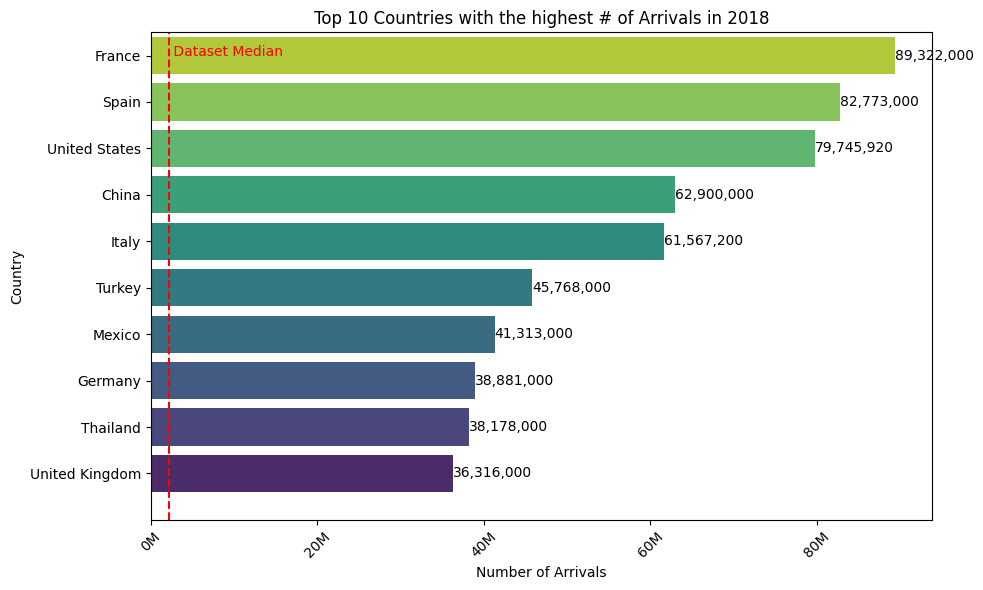

In [35]:
# 1. Query to retrieve the data for the top 10 countries with the highest number of arrivals in 2018
query_top_10 = "SELECT country_name, \"2018\" FROM refined_inbound ORDER BY \"2018\" DESC LIMIT 10"

# Query to calculate the median number of arrivals for all countries in 2018
query_median = "SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY \"2018\") FROM refined_inbound"

# Execute the query to calculate the median number of arrivals
cursor.execute(query_median)
median_value = cursor.fetchone()[0]

# Execute the query to retrieve the top 10 countries
df_top_10 = pd.read_sql(query_top_10, conn)

# Reverse the DataFrame to display the chart in descending order
df_top_10 = df_top_10.sort_values(by='2018', ascending=True)

# Create a bar plot using seaborn for the top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x='2018', y='country_name', data=df_top_10, palette='viridis')

# Add a horizontal line for the median value
plt.axvline(x=median_value, color='red', linestyle='--')

# Calculate y_position as the midpoint of the y-axis range
y_position = (plt.ylim()[0] + plt.ylim()[1])

# Add text for the median label with offsets
plt.text(median_value, y_position, ' Dataset Median', color='red', transform=plt.gca().transData)

# Set the title and labels
plt.title('Top 10 Countries with the highest # of Arrivals in 2018')
plt.xlabel('Number of Arrivals')
plt.ylabel('Country')

# Format the x-axis tick labels as millions
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: locale.format_string('%.0fM', x / 1e6)))

# Set the y-axis limits to include all countries
plt.ylim(-1, len(df_top_10) - 0.5)

# Adjust the margins and rotate the y-axis labels
plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.2)  # Adjust the margins as needed
plt.xticks(rotation=45)

# Remove the grid
plt.grid(False)

# Add the values of the numbers to the plot with thousand separator
for i, value in enumerate(df_top_10['2018']):
    formatted_value = f"{value:,.0f}"
    plt.text(value, i, formatted_value, ha='left', va='center', color='black')

# Adjust the layout
plt.tight_layout()
    
# Display the plot
plt.show()

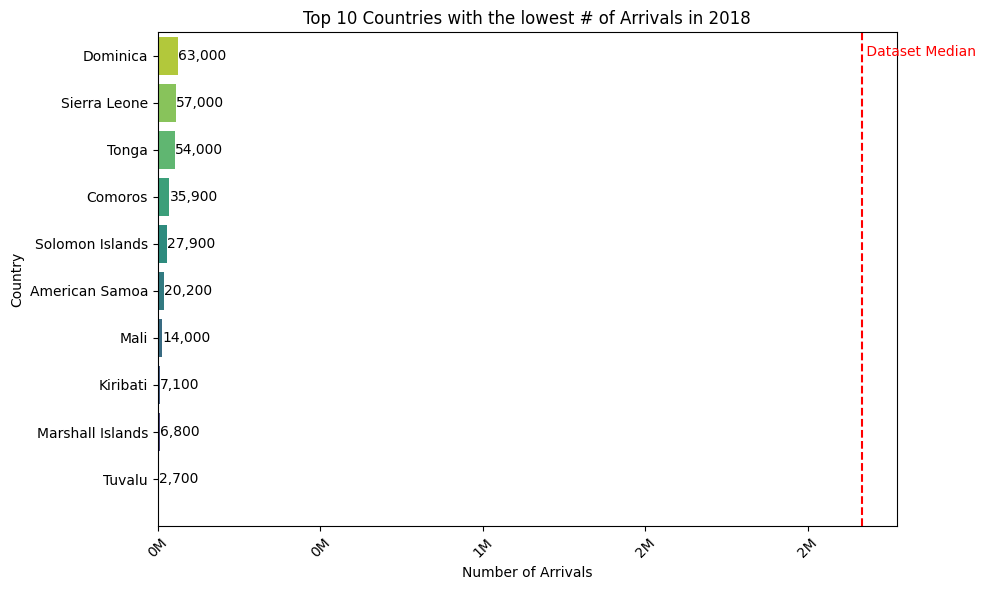

In [36]:
# 2. Query to retrieve the data for the top 10 countries with the lowest number of arrivals in 2018
query_top_10 = "SELECT country_name, \"2018\" FROM refined_inbound ORDER BY \"2018\" ASC LIMIT 10"

# Query to calculate the median number of arrivals for all countries in 2018
query_median = "SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY \"2018\") FROM refined_inbound"

# Execute the query to calculate the median number of arrivals
cursor.execute(query_median)
median_value = cursor.fetchone()[0]

# Execute the query to retrieve the top 10 countries
df_top_10 = pd.read_sql(query_top_10, conn)

# Reverse the DataFrame to display the chart in descending order
df_top_10 = df_top_10.sort_values(by='2018', ascending=True)

# Create a bar plot using seaborn for the top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x='2018', y='country_name', data=df_top_10, palette='viridis')

# Set the x and y offsets for the text label
x_offset = 20  # Number of pixels to offset the text label from the line
y_offset = 0  # Number of pixels to offset the text label vertically

# Add a horizontal line for the median value
plt.axvline(x=median_value, color='red', linestyle='--')

# Add text for the median label with offsets
plt.text(median_value + x_offset, y_position + y_offset, ' Dataset Median', color='red', transform=plt.gca().transData)

# Set the title and labels
plt.title('Top 10 Countries with the lowest # of Arrivals in 2018')
plt.xlabel('Number of Arrivals')
plt.ylabel('Country')

# Format the x-axis tick labels as millions
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: locale.format_string('%.0fM', x / 1e6)))

# Set the y-axis limits to include all countries
plt.ylim(-1, len(df_top_10) - 0.5)

# Adjust the margins and rotate the y-axis labels
plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.2)  # Adjust the margins as needed
plt.xticks(rotation=45)

# Remove the grid
plt.grid(False)

# Add the values of the numbers to the plot with thousand separator
for i, value in enumerate(df_top_10['2018']):
    formatted_value = f"{value:,.0f}"
    plt.text(value, i, formatted_value, ha='left', va='center', color='black')

# Adjust the layout
plt.tight_layout()
    
# Display the plot
plt.show()

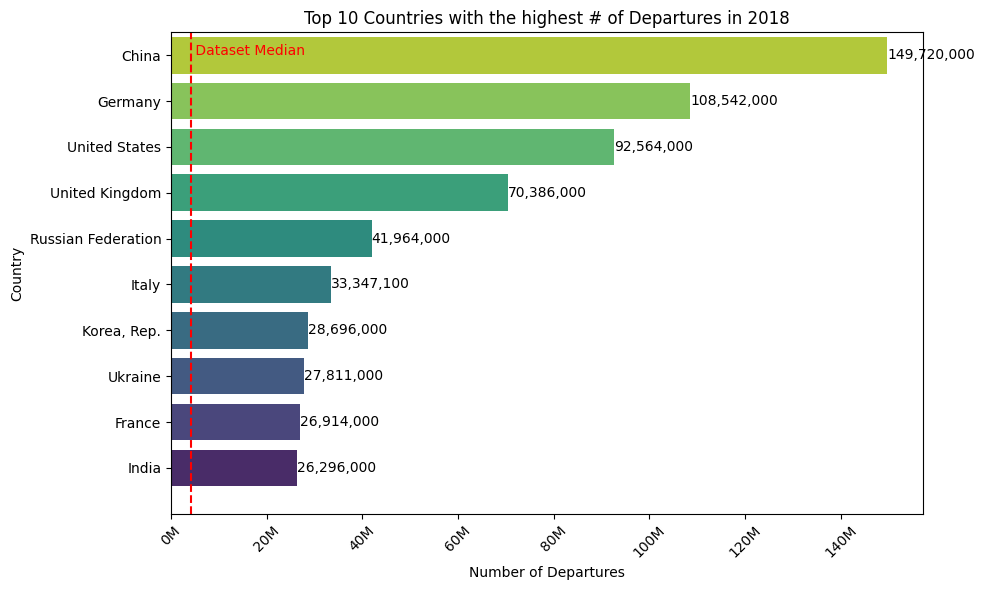

In [37]:
# 3. Query to retrieve the data for the top 10 countries with the highest number of departures in 2018
query_top_10 = "SELECT country_name, \"2018\" FROM refined_outbound ORDER BY \"2018\" DESC LIMIT 10"

# Query to calculate the median number of arrivals for all countries in 2018
query_median = "SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY \"2018\") FROM refined_outbound"

# Execute the query to calculate the median number of arrivals
cursor.execute(query_median)
median_value = cursor.fetchone()[0]

# Execute the query to retrieve the top 10 countries
df_top_10 = pd.read_sql(query_top_10, conn)

# Reverse the DataFrame to display the chart in descending order
df_top_10 = df_top_10.sort_values(by='2018', ascending=True)

# Create a bar plot using seaborn for the top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x='2018', y='country_name', data=df_top_10, palette='viridis')

# Set the x and y offsets for the text label
x_offset = 20  # Number of pixels to offset the text label from the line
y_offset = 0  # Number of pixels to offset the text label vertically

# Add a horizontal line for the median value
plt.axvline(x=median_value, color='red', linestyle='--')

# Add text for the median label with offsets
plt.text(median_value + x_offset, y_position + y_offset, ' Dataset Median', color='red', transform=plt.gca().transData)

# Set the title and labels
plt.title('Top 10 Countries with the highest # of Departures in 2018')
plt.xlabel('Number of Departures')
plt.ylabel('Country')

# Format the x-axis tick labels as millions
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: locale.format_string('%.0fM', x / 1e6)))

# Set the y-axis limits to include all countries
plt.ylim(-1, len(df_top_10) - 0.5)

# Adjust the margins and rotate the y-axis labels
plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.2)  # Adjust the margins as needed
plt.xticks(rotation=45)

# Remove the grid
plt.grid(False)

# Add the values of the numbers to the plot with thousand separator
for i, value in enumerate(df_top_10['2018']):
    formatted_value = f"{value:,.0f}"
    plt.text(value, i, formatted_value, ha='left', va='center', color='black')

# Adjust the layout
plt.tight_layout()
    
# Display the plot
plt.show()

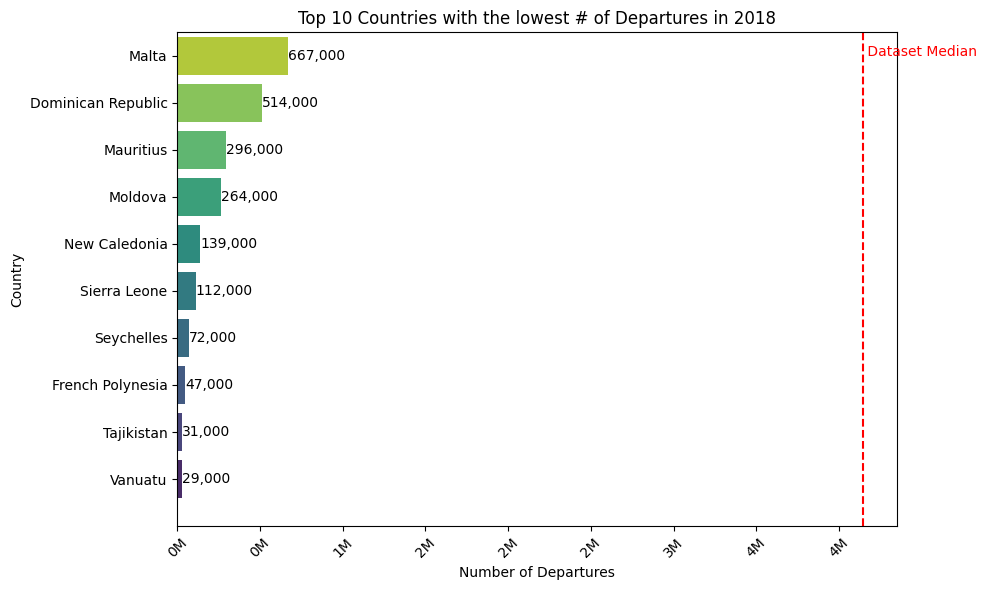

In [38]:
# 4. Query to retrieve the data for the top 10 countries with the lowest number of departures in 2018
query_top_10 = "SELECT country_name, \"2018\" FROM refined_outbound ORDER BY \"2018\" ASC LIMIT 10"

# Query to calculate the median number of arrivals for all countries in 2018
query_median = "SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY \"2018\") FROM refined_outbound"

# Execute the query to calculate the median number of arrivals
cursor.execute(query_median)
median_value = cursor.fetchone()[0]

# Execute the query to retrieve the top 10 countries
df_top_10 = pd.read_sql(query_top_10, conn)

# Reverse the DataFrame to display the chart in descending order
df_top_10 = df_top_10.sort_values(by='2018', ascending=True)

# Create a bar plot using seaborn for the top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x='2018', y='country_name', data=df_top_10, palette='viridis')

# Set the x and y offsets for the text label
x_offset = 20  # Number of pixels to offset the text label from the line
y_offset = 0  # Number of pixels to offset the text label vertically

# Add a horizontal line for the median value
plt.axvline(x=median_value, color='red', linestyle='--')

# Add text for the median label with offsets
plt.text(median_value + x_offset, y_position + y_offset, ' Dataset Median', color='red', transform=plt.gca().transData)

# Set the title and labels
plt.title('Top 10 Countries with the lowest # of Departures in 2018')
plt.xlabel('Number of Departures')
plt.ylabel('Country')

# Format the x-axis tick labels as millions
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: locale.format_string('%.0fM', x / 1e6)))

# Set the y-axis limits to include all countries
plt.ylim(-1, len(df_top_10) - 0.5)

# Adjust the margins and rotate the y-axis labels
plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.2)  # Adjust the margins as needed
plt.xticks(rotation=45)

# Remove the grid
plt.grid(False)

# Add the values of the numbers to the plot with thousand separator
for i, value in enumerate(df_top_10['2018']):
    formatted_value = f"{value:,.0f}"
    plt.text(value, i, formatted_value, ha='left', va='center', color='black')

# Adjust the layout
plt.tight_layout()
    
# Display the plot
plt.show()

In [39]:
query = '''
WITH inbound_data AS (
    SELECT country_name, "2018"::FLOAT AS inbound_2018
    FROM refined_inbound
),
outbound_data AS (
    SELECT country_name, "2018"::FLOAT AS outbound_2018
    FROM refined_outbound
)
SELECT inbound_data.country_name, inbound_data.inbound_2018, outbound_data.outbound_2018,
       ROUND(CAST(inbound_data.inbound_2018 / outbound_data.outbound_2018 AS NUMERIC), 1) AS io_ratio,
       ROUND(CAST(outbound_data.outbound_2018 / inbound_data.inbound_2018 AS NUMERIC), 1) AS oi_ratio
FROM inbound_data
JOIN outbound_data ON inbound_data.country_name = outbound_data.country_name
ORDER BY io_ratio DESC;

'''

cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description]).head(5)
df

,country_name,inbound_2018,outbound_2018,io_ratio,oi_ratio
0,Tajikistan,1035000,31000,33.4,0.0
1,Belarus,11501600,836000,13.8,0.1
2,Dominican Republic,6569000,514000,12.8,0.1
3,Croatia,16645000,2058000,8.1,0.1
4,Portugal,16186000,2486000,6.5,0.2


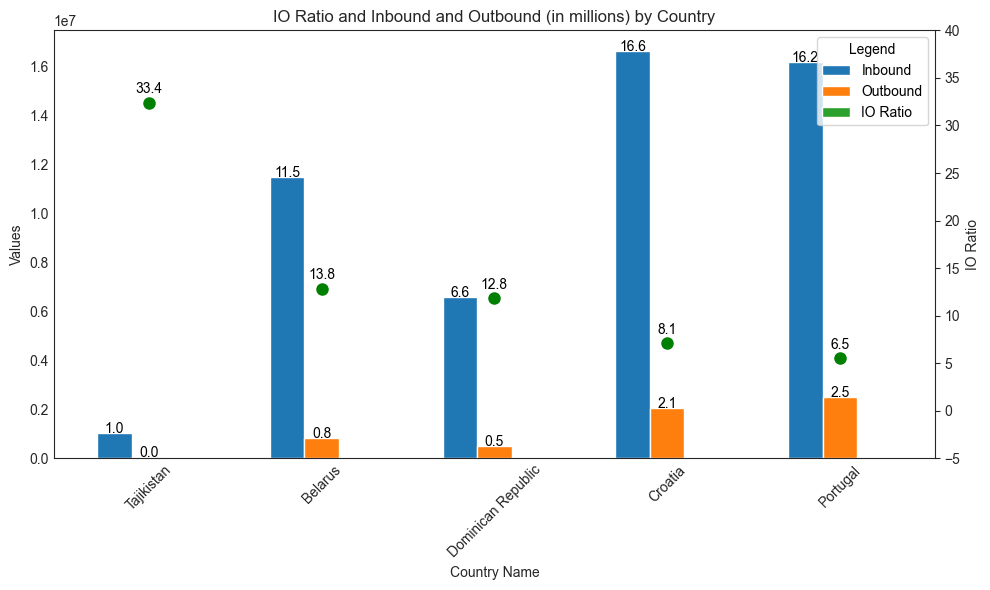

In [40]:
## 5. What are the top 5 countries with the high arrival/departure (inbound/outbout) ratio?

# Convert io_ratio to float
df['io_ratio'] = df['io_ratio'].astype(float)

sns.set_style("white")  # Set the style of the seaborn chart to "white"

fig, ax1 = plt.subplots(figsize=(10, 6))  # Set the size of the figure

# Rest of your code...

# Remove all spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Remove all ticks
ax1.tick_params(axis='both', which='both', length=0)


# Hide the gridlines
ax1.grid(False)

# Plot the bars
df.set_index('country_name').plot(kind='bar', width=0.6, ax=ax1)

# Add value labels for bars
for index, row in df.iterrows():
    plt.text(index - 0.20, row['inbound_2018'], '{:,.1f}'.format(row['inbound_2018']/1000000), color='black', ha='center')
    plt.text(index, row['outbound_2018'], '{:,.1f}'.format(row['outbound_2018']/1000000), color='black', ha='center')

# Create a secondary y-axis for io_ratio
ax2 = ax1.twinx()

# Plot the io_ratio values
ax2.plot(df.index, df['io_ratio'] - 1, 'go', markersize=8)

# Add value labels for io_ratio
for index, row in df.iterrows():
    ax2.text(index, row['io_ratio'], '{:,.1f}'.format(row['io_ratio']), color='black', ha='center')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)    
ax1.set_xlabel('Country Name')  # Set the x-axis label
ax1.set_ylabel('Values')  # Set the y-axis label for bars
ax2.set_ylabel('IO Ratio')  # Set the y-axis label for io_ratio

plt.title('IO Ratio and Inbound and Outbound (in millions) by Country')  # Set the title of the chart

# Create the legend with the appropriate labels
legend_labels = ['Inbound', 'Outbound', 'IO Ratio']
ax1.legend(legend_labels, loc='upper right')

ax2.set_ylim(-5, 40)  # Set the y-axis limits for the IO ratio

# Set the legend title
legend_title = 'Legend'
legend = ax1.legend(legend_labels, title=legend_title, loc='upper right')

# Set the color of the legend title
legend.get_title().set_color('black')

# Set the color of the legend labels
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()  # Adjust the layout to prevent overlapping

plt.show()  # Display the chart

In [41]:
query = '''
WITH inbound_data AS (
    SELECT country_name, "2018"::FLOAT AS inbound_2018
    FROM refined_inbound
),
outbound_data AS (
    SELECT country_name, "2018"::FLOAT AS outbound_2018
    FROM refined_outbound
)
SELECT inbound_data.country_name, inbound_data.inbound_2018, outbound_data.outbound_2018,
       ROUND(CAST(inbound_data.inbound_2018 / outbound_data.outbound_2018 AS NUMERIC), 1) AS io_ratio,
       ROUND(CAST(outbound_data.outbound_2018 / inbound_data.inbound_2018 AS NUMERIC), 1) AS oi_ratio
FROM inbound_data
JOIN outbound_data ON inbound_data.country_name = outbound_data.country_name
ORDER BY oi_ratio DESC;

'''

cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description]).head(5)
df

,country_name,inbound_2018,outbound_2018,io_ratio,oi_ratio
0,Kyrgyz Republic,423000,6839000,0.1,16.2
1,Finland,3224000,9450000,0.3,2.9
2,Germany,38881000,108542000,0.4,2.8
3,China,62900000,149720000,0.4,2.4
4,Eswatini,782000,1717000,0.5,2.2


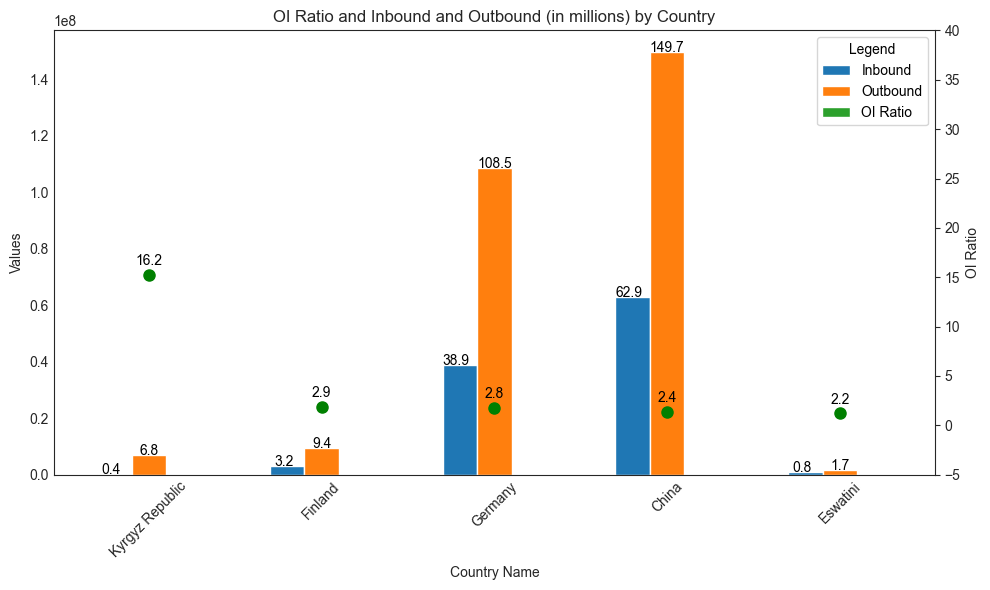

In [42]:
## 5. What are the top 5 countries with the high departure/arrival (outbout/inbound) ratio?

# Convert io_ratio to float
df['oi_ratio'] = df['oi_ratio'].astype(float)

sns.set_style("white")  # Set the style of the seaborn chart to "white"

fig, ax1 = plt.subplots(figsize=(10, 6))  # Set the size of the figure

# Remove all spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# Remove all ticks
ax1.tick_params(axis='both', which='both', length=0)

# Hide the gridlines
ax1.grid(False)

# Plot the bars
df.set_index('country_name').plot(kind='bar', width=0.6, ax=ax1)

# Add value labels for bars
for index, row in df.iterrows():
    plt.text(index - 0.22, row['inbound_2018'], '{:,.1f}'.format(row['inbound_2018']/1000000), color='black', ha='center')
    plt.text(index, row['outbound_2018'], '{:,.1f}'.format(row['outbound_2018']/1000000), color='black', ha='center')

# Create a secondary y-axis for io_ratio
ax2 = ax1.twinx()

# Plot the io_ratio values
ax2.plot(df.index, df['oi_ratio'] - 1, 'go', markersize=8)

# Add value labels for io_ratio
for index, row in df.iterrows():
    ax2.text(index, row['oi_ratio'], '{:,.1f}'.format(row['oi_ratio']), color='black', ha='center')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)    
ax1.set_xlabel('Country Name')  # Set the x-axis label
ax1.set_ylabel('Values')  # Set the y-axis label for bars
ax2.set_ylabel('OI Ratio')  # Set the y-axis label for io_ratio

plt.title('OI Ratio and Inbound and Outbound (in millions) by Country')  # Set the title of the chart

# Create the legend with the appropriate labels
legend_labels = ['Inbound', 'Outbound', 'OI Ratio']
ax1.legend(legend_labels, loc='upper right')

ax2.set_ylim(-5, 40)  # Set the y-axis limits for the IO ratio

# Set the legend title
legend_title = 'Legend'
legend = ax1.legend(legend_labels, title=legend_title, loc='upper right')

# Set the color of the legend title
legend.get_title().set_color('black')

# Set the color of the legend labels
for text in legend.get_texts():
    text.set_color('black')

plt.tight_layout()  # Adjust the layout to prevent overlapping

plt.show()  # Display the chart

In [43]:
query = "SELECT * FROM refined_inbound;"
cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description])

# Calculate the difference between 2018 and 2014 values
df['difference'] = df['2018'] - df['2014']

# Calculate the percentage difference between 2018 and 2014 values
df['percent_difference'] = (df['2018'] - df['2014']) / df['2014'] * 100

# Sort the DataFrame by the 'difference' column in descending order
df_sorted = df.sort_values('percent_difference', ascending=False).head(5)

df_sorted

,country_name,country_code,2014,2015,2016,2017,2018,difference,percent_difference
151,Tajikistan,TJK,213000,414000,344000,431000,1035000,822000,386
31,Cote d'Ivoire,CIV,471000,1441000,1583000,1800000,1965000,1494000,317
58,"Gambia, The",GMB,156000,449000,450000,522000,552000,396000,254
162,Uzbekistan,UZB,1862000,1918000,2027000,2690000,5346000,3484000,187
71,Iceland,ISL,997000,1289000,1792000,2225000,2343800,1346800,135


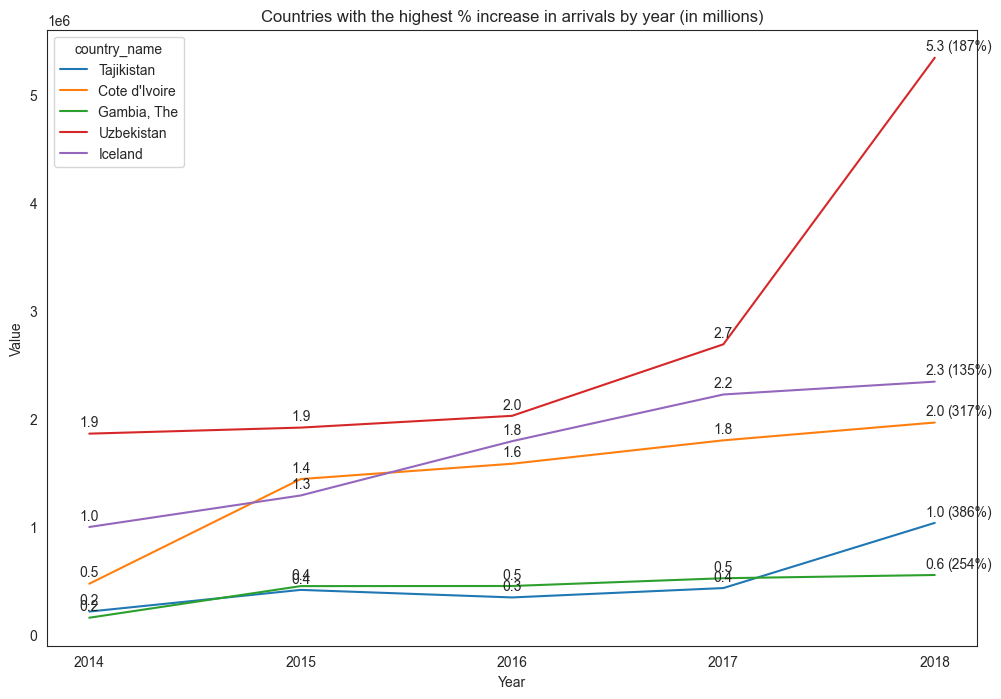

In [44]:
## 7. Which country had the highest increase in the number of arrivals from 2014 to 2018?

# Set the style for the plot (optional)
sns.set_style("white")

# Increase the width of the figure
plt.figure(figsize=(12, 8))

# Create a copy of the dataframe with only the necessary columns
df_plot = df_sorted[['country_name', '2014', '2015', '2016', '2017', '2018', 'percent_difference']]

# Reshape the DataFrame to a long-form format
df_plot = df_plot.melt(id_vars=['country_name', 'percent_difference'], var_name='Year', value_name='Value')

# Create the seaborn plot with separate lines for each year
sns.lineplot(data=df_plot, x='Year', y='Value', hue='country_name')

# Annotate the data points with values and percent_difference for 2018
for _, row in df_plot.iterrows():
    if row['Year'] == '2018':
        plt.annotate(round(row['Value']/1000000,1), (row['Year'], row['Value']),
                     textcoords="offset points", xytext=(0, 5), ha='center')
        plt.annotate(f"({round(row['percent_difference'])}%)", (row['Year'], row['Value']),
                     textcoords="offset points", xytext=(25, 5), ha='center')
    else:
        plt.annotate(round(row['Value']/1000000,1), (row['Year'], row['Value']),
                     textcoords="offset points", xytext=(0, 5), ha='center')

# Set the title and labels for the plot
plt.title('Countries with the highest % increase in arrivals by year (in millions)')
plt.xlabel('Year')
plt.ylabel('Value')

# Show the plot
plt.show()


In [45]:
query = "SELECT * FROM refined_outbound;"
cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description])

# Calculate the difference between 2018 and 2014 values
df['difference'] = df['2018'] - df['2014']

# Calculate the percentage difference between 2018 and 2014 values
df['percent_difference'] = (df['2018'] - df['2014']) / df['2014'] * 100

# Sort the DataFrame by the 'difference' column in descending order
df_sorted = df.sort_values('percent_difference', ascending=False).head(5)

df_sorted

,country_name,country_code,2014,2015,2016,2017,2018,difference,percent_difference
65,Paraguay,PRY,426000,1008000,1503000,1548000,1266000,840000,197
43,Cambodia,KHM,956000,1194000,1434000,1752000,1995000,1039000,109
22,Algeria,DZA,2839000,3638000,4530000,5058000,5610000,2771000,98
42,Kyrgyz Republic,KGZ,3790000,4008000,4185000,4446000,6839000,3049000,80
44,"Korea, Rep.",KOR,16081000,19310000,22383000,26496000,28696000,12615000,78


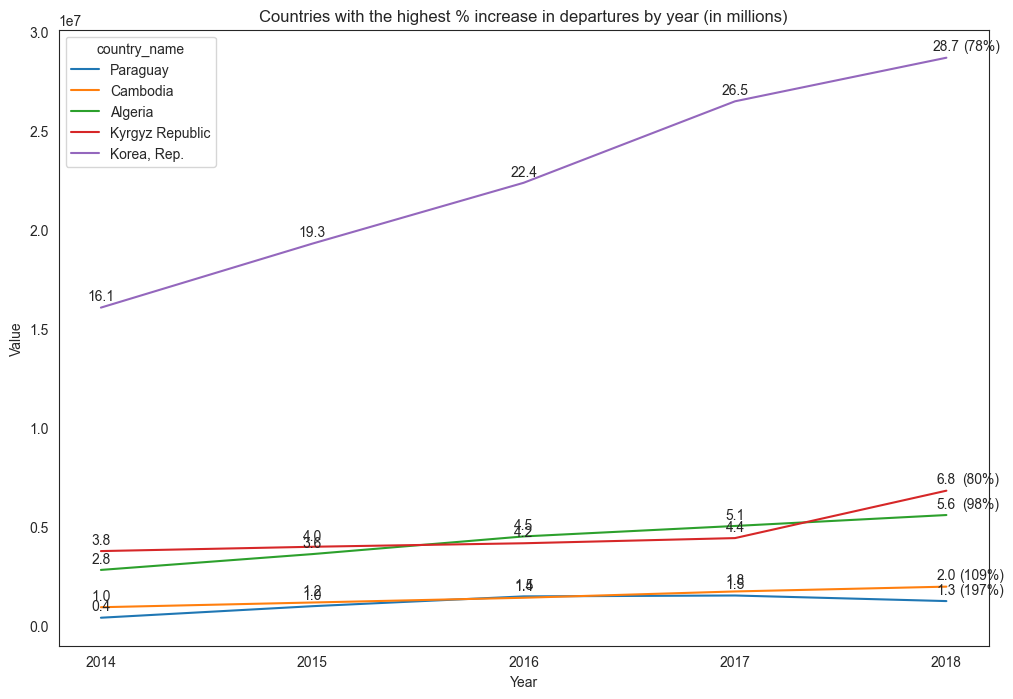

In [46]:
## 8. Which country had the highest increase in the number of departures from 2014 to 2018?

# Set the style for the plot (optional)
sns.set_style("white")

# Increase the width of the figure
plt.figure(figsize=(12, 8))

# Create a copy of the dataframe with only the necessary columns
df_plot = df_sorted[['country_name', '2014', '2015', '2016', '2017', '2018', 'percent_difference']]

# Reshape the DataFrame to a long-form format
df_plot = df_plot.melt(id_vars=['country_name', 'percent_difference'], var_name='Year', value_name='Value')

# Create the seaborn plot with separate lines for each year
sns.lineplot(data=df_plot, x='Year', y='Value', hue='country_name')

# Annotate the data points with values and percent_difference for 2018
for _, row in df_plot.iterrows():
    if row['Year'] == '2018':
        plt.annotate(round(row['Value']/1000000,1), (row['Year'], row['Value']),
                     textcoords="offset points", xytext=(0, 5), ha='center')
        plt.annotate(f"({round(row['percent_difference'])}%)", (row['Year'], row['Value']),
                     textcoords="offset points", xytext=(25, 5), ha='center')
    else:
        plt.annotate(round(row['Value']/1000000,1), (row['Year'], row['Value']),
                     textcoords="offset points", xytext=(0, 5), ha='center')

# Set the title and labels for the plot
plt.title('Countries with the highest % increase in departures by year (in millions)')
plt.xlabel('Year')
plt.ylabel('Value')

# Show the plot
plt.show()

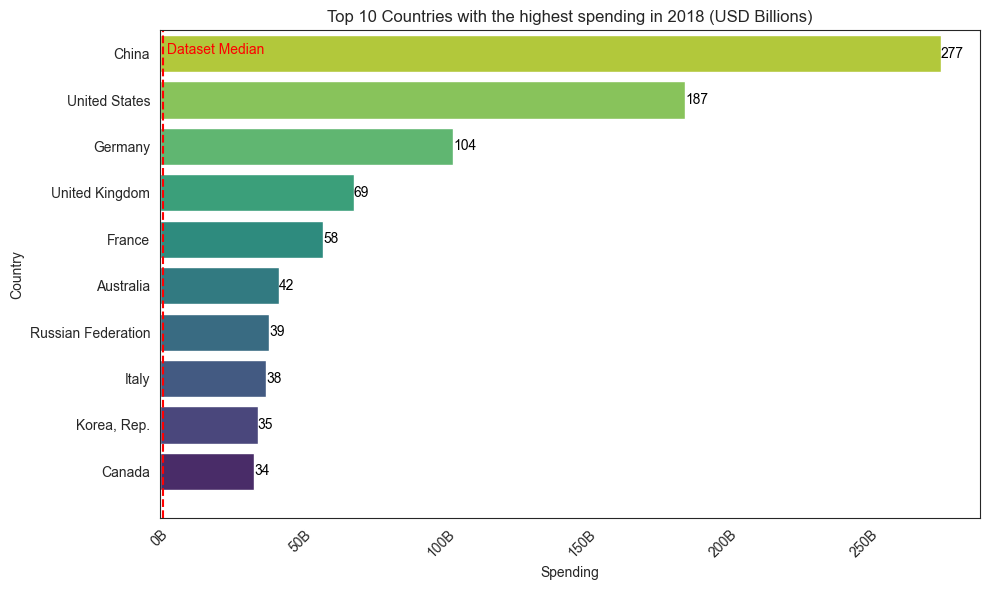

In [47]:
# 9. Query to retrieve the data for the top 10 countries with the highest spending in 2018
query_top_10 = "SELECT country_name, \"2018\" FROM refined_expenditure ORDER BY \"2018\" DESC LIMIT 10"

# Query to calculate the median number of arrivals for all countries in 2018
query_median = "SELECT percentile_cont(0.5) WITHIN GROUP (ORDER BY \"2018\") FROM refined_expenditure"

# Execute the query to calculate the median number of arrivals
cursor.execute(query_median)
median_value = cursor.fetchone()[0]

# Execute the query to retrieve the top 10 countries
df_top_10 = pd.read_sql(query_top_10, conn)

# Reverse the DataFrame to display the chart in descending order
df_top_10 = df_top_10.sort_values(by='2018', ascending=True)

# Create a bar plot using seaborn for the top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x='2018', y='country_name', data=df_top_10, palette='viridis')

# Set the x and y offsets for the text label
x_offset = 20  # Number of pixels to offset the text label from the line
y_offset = 0  # Number of pixels to offset the text label vertically

# Add a horizontal line for the median value
plt.axvline(x=median_value, color='red', linestyle='--')

# Add text for the median label with offsets
plt.text(median_value + x_offset, y_position + y_offset, ' Dataset Median', color='red', transform=plt.gca().transData)

# Set the title and labels
plt.title('Top 10 Countries with the highest spending in 2018 (USD Billions)')
plt.xlabel('Spending')
plt.ylabel('Country')

# Set the y-axis limits to include all countries
plt.ylim(-1, len(df_top_10) - 0.5)

# Adjust the margins and rotate the y-axis labels
plt.xticks(rotation=45)

# Format the x-axis tick labels as millions
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, _: locale.format_string('%.0fB', x/1000000000)))

# Remove the grid
plt.grid(False)

# Add the values of the numbers to the plot with thousand separator
for i, value in enumerate(df_top_10['2018']):
    formatted_value = f"{value/1000000000:,.0f}"
    plt.text(value, i, formatted_value, ha='left', va='center', color='black')

# Adjust the layout
plt.tight_layout()
    
# Display the plot
plt.show()

In [48]:
## 10. What are the top 10 countries with the highest spending per arrivals and how does these compare to the median spending?

query = '''
WITH inbound_data AS (
    SELECT country_name, "2018"::FLOAT AS inbound_2018
    FROM refined_inbound
),
expenditure_data AS (
    SELECT country_name, "2018"::FLOAT AS expenditure_2018
    FROM refined_expenditure
)
SELECT inbound_data.country_name, inbound_data.inbound_2018, expenditure_data.expenditure_2018,
       ROUND(CAST(expenditure_data.expenditure_2018 / inbound_data.inbound_2018 AS NUMERIC), 1) AS expenditure_rate
FROM inbound_data
JOIN expenditure_data ON inbound_data.country_name = expenditure_data.country_name
ORDER BY expenditure_rate DESC;
'''

cursor.execute(query)
results = cursor.fetchall()

df = pd.DataFrame(results, columns=[desc[0] for desc in cursor.description]).head(10)
df

,country_name,inbound_2018,expenditure_2018,expenditure_rate
0,Qatar,1819300,11754000000,6460.7
1,Marshall Islands,6800,31400000,4617.6
2,Australia,9246000,42351000000,4580.5
3,China,62900000,277345000000,4409.3
4,Angola,218000,762000000,3495.4
5,Brazil,6621000,22229000000,3357.3
6,Norway,5688000,18592000000,3268.6
7,Lebanon,1964000,6395000000,3256.1
8,Luxembourg,1018000,3290000000,3231.8
9,Moldova,160000,438000000,2737.5


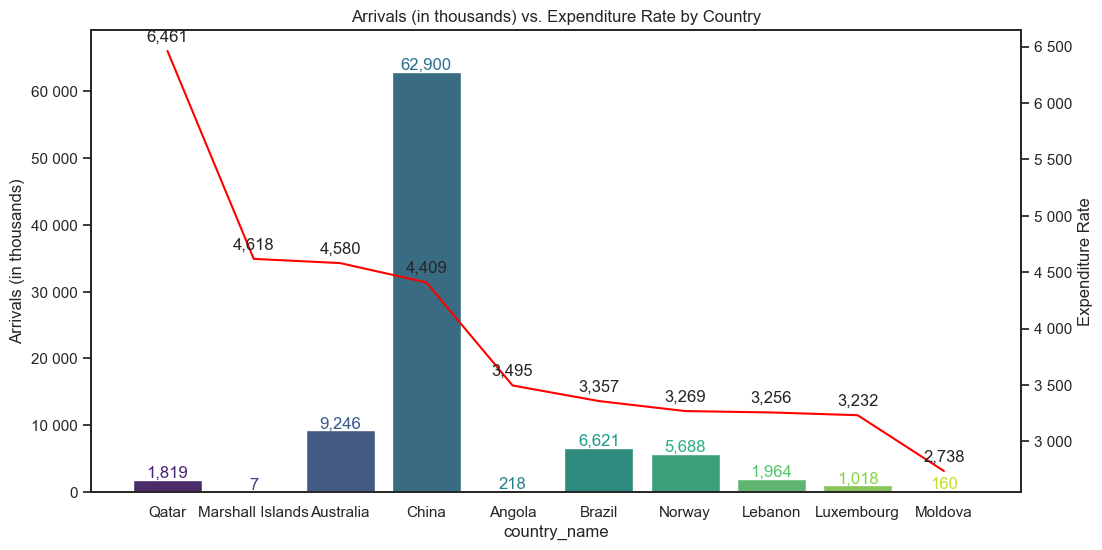

In [49]:
# Divide inbound_2018 values by 1000
df['inbound_2018'] = df['inbound_2018'] / 1000

# Create the seaborn visualization with viridis color palette
sns.set(style="white")
plt.figure(figsize=(12, 6))
colors = sns.color_palette("viridis", len(df))

# Plot the inbound_2018 values with values displayed on top
ax = sns.barplot(data=df, x='country_name', y='inbound_2018', palette=colors)
plt.ylabel('Arrivals (in thousands)')

# Display the values on top of the columns
for i, p in enumerate(ax.patches):
    ax.annotate('{:,.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', color=colors[i])

# Set y-axis limits based on data range
ax.set_ylim(0, df['inbound_2018'].max() * 1.1)

# Format y-axis ticks to separate values by thousands
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', ' ')))

# Create a second y-axis for expenditure_rate
ax2 = plt.twinx()
sns.lineplot(data=df, x='country_name', y='expenditure_rate', color='red', ax=ax2)
ax2.set_ylabel('Expenditure Rate')

# Display the values on top of the line plot
for i, row in df.iterrows():
    ax2.annotate('{:,.0f}'.format(row['expenditure_rate']), (i, row['expenditure_rate']), 
                 ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Format y-axis ticks to separate values by thousands for expenditure_rate
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(',', ' ')))

# Customize the plot
plt.title('Arrivals (in thousands) vs. Expenditure Rate by Country')
plt.xlabel('Country')
plt.xticks(rotation=90)

# Display the plot
plt.show()